# **[exercise 2]** Energy System Analysis and Evaluation
In this notebook you are prompted to **understand the basics of data science** to examine *time series data* and aggregate it. Furthermore you are required to learn **basic financial mathematics** to evaluate the *profitability of financial assets*.

Furthermore we will cover the following Python basics:
- [x] Matplotlib
- [x] Pandas
- [x] Dictionaries
- [x] Classes

In [1]:
# Let us import the most important packages first
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from visualization import carpet_plot
import warnings

# Suppress warnings that packages might be outdated in the future
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%run installation.py ;

## Demand Structure

A distinctive energy system definition is core to every energy system analysis and evaluation approach. In the present case the term building energy system refers to the components necessary for the energy supply of the single family home. Within this system, we focus on the components for the heat supply of the building. Those elements are schematically depicted in the following Figure 1 for the different heat supply options outlined.

![Building Energy System](../../datasets/mes/exercise_2/figures/building_energy_system.png "Building Energy System")

Figure 1: Heat supply options of a single family home with a) gas condensing boiler b) pellet heater c) air-water heat pump d) brine-water heat pump within the building energy system

In order to find proper supply options for a building energy system, it is necessary to identify the demand structure. The essential energy demand in our scope of consideration comprises the heat demand (room heating and warm water).

In [3]:
import demandlib.bdew as bdew

# read standard load profiles
e_slp = bdew.ElecSlp(2021)

# multiply given annual demand with timeseries
elec_demand = e_slp.get_profile(ann_el_demand_per_sector= {"h0_dyn": 3000})
elec_demand

h0_dyn
2021-01-01 00:00:00  0.251917
2021-01-01 00:15:00  0.226729
2021-01-01 00:30:00  0.204522
2021-01-01 00:45:00  0.186041
2021-01-01 01:00:00  0.172329
...                       ...
2021-12-31 22:45:00  0.401292
2021-12-31 23:00:00  0.371845
2021-12-31 23:15:00  0.342396
2021-12-31 23:30:00  0.313098
2021-12-31 23:45:00  0.284406

[35040 rows x 1 columns]

Be aware that the values in the DataFrame are 15 minute values with a power unit. If you sum up a table with 15min values the result will be of the unit 'kW/15minutes'. You will have to divide the result by 4 to get kWh.

In [4]:
elec_demand.sum() / 4

h0_dyn    3000.027691
dtype: float64

Or resample the DataFrame to hourly values using the ``.mean()`` method.

<AxesSubplot: xlabel='Date', ylabel='Power demand'>

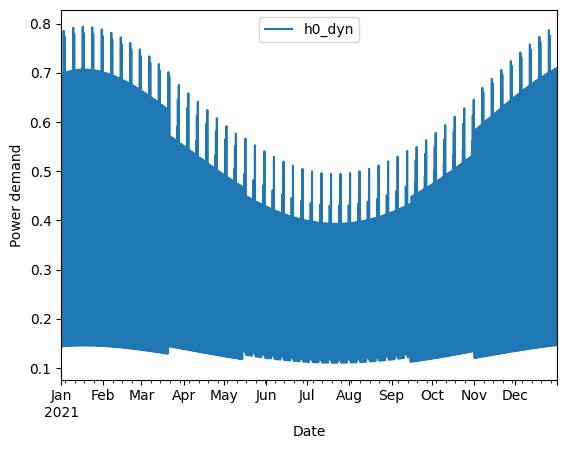

In [5]:
# Resample 15-minute values to hourly values.
elec_demand_resampled = elec_demand.resample("H").mean()
elec_demand_resampled.plot(xlabel="Date", ylabel="Power demand")

In [6]:
carpet_plot(elec_demand_resampled["h0_dyn"], axis="electricity demand [$kWh$]")

/home/skortmann/multi-energy-systems/exercise_2/visualization.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [7]:
from utils import getTemperatures

# Define some Locations to choose from in Latitude and Longitude
locations = {
    'Aachen' : ['50.778620', '6.075170']
}

hourly_temperatures_ac = getTemperatures(locations, 'Aachen', start_date = "2021-01-01", end_date = "2021-12-31")
df_temperature = pd.DataFrame(data = hourly_temperatures_ac[1], index = pd.to_datetime(hourly_temperatures_ac[0]), columns=["Aachen [°C]"])
df_temperature.plot(title="Temperature")

<AxesSubplot: title={'center': 'Temperature'}>

In [8]:
# Single family house (efh: Einfamilienhaus)
heat_demand = bdew.HeatBuilding(
    pd.date_range(start='2021-01-01 00:00', end='2021-12-31 23:00', freq='H'),
    temperature=df_temperature["Aachen [°C]"],
    shlp_type="EFH",
    building_class=1,
    wind_class=1,
    annual_heat_demand=25000,
    name="EFH",
).get_bdew_profile()
heat_demand

2021-01-01 00:00:00    1.833224
2021-01-01 01:00:00    1.927720
2021-01-01 02:00:00    2.022216
2021-01-01 03:00:00    2.324603
2021-01-01 04:00:00    3.146719
                         ...   
2021-12-31 19:00:00    2.631550
2021-12-31 20:00:00    2.537060
2021-12-31 21:00:00    2.215794
2021-12-31 22:00:00    1.412627
2021-12-31 23:00:00    0.845687
Freq: H, Name: temperature_geo, Length: 8760, dtype: float64

In [9]:
# Plot demand of building
heat_demand.plot(xlabel="Date", ylabel="Heat demand in [$kW$]")

<AxesSubplot: xlabel='Date', ylabel='Heat demand in [$kW$]'>

In [10]:
carpet_plot(heat_demand, axis="heat demand [$kWh_{th}$]")

/home/skortmann/multi-energy-systems/exercise_2/visualization.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


## Task 1 : Time Series Analysis <a class="anchor" id="task-1--tsa"></a>
The analysis of time series data for demand is of high importance to plan the installation capacity for example heating infrastructure.

### Task 1.1 : Identify the maximum heat demand <a class="anchor" id="#task-11--identify-the-maximum-heat-demand"></a>

**Task description:** Identify the maximum and total amount of heating that is used by the househould and save it in two variables called `max_heat_demand` and `total_heat_demand`.

In [11]:
max_heat_demand = heat_demand.max()
max_heat_demand
total_heat_demand = heat_demand.sum()
max_heat_demand

12.071616221773615

<div class="alert alert-block alert-success">
<b>Solution:</b> The total heat demand is 25001 $kWh$ and the max heat demand is 11.94 $kW$.
</div>

### Task 1.3 : Calculate the heating degree days <a class="anchor" id="#task-13--calculate-hdd"></a>

The Heating Degree Days (HDD) is a measure of how much heating is needed to maintain a comfortable temperature inside a building. If the average outdoor temperature of a day is below a certain threshold (Europe: 15.5 °C) - this is the heating limit temperature - it is called a heating day. The heating degree days are calculated by adding up the differences between the heating limit temperature and the average outdoor temperature for all heating days.

$$ HDD = \sum_{i=1}^{n} \max(0, T_{ref} - T_{avg,i}) $$

where $HDD$ is the total Heating Degree Days, $n$ is the total number of days in the period considered, $T_{ref}$ is the reference temperature and $T_{avg}$ is the average temperature. The max functions ensures to consider only the days that are below the reference temperature.

**Task description:** Define a function to calculate the heating degree days.

In [12]:
def calc_hdd(temp_time_steps: list, base_temp: float) -> float:
    hdd = 0
    
    for temp in temp_time_steps:
        if max(0, base_temp-temp) > 0:
            hdd += base_temp-temp
            
    return hdd

**Task description:** Calculate the average temperature for each day. Store the average temperature to a list.

In [13]:
hourly_temperatures = hourly_temperatures_ac[1]
daily_average_temperatures = []
daily_total = 0
count = 0

for temperature in hourly_temperatures:
    daily_total += temperature
    count += 1
    if count == 24:
        daily_average = daily_total / 24
        daily_average_temperatures.append(daily_average)
        daily_total = 0
        count = 0

**Task description:** Calculate the heating degree days for a base temperature of 15.5 °C.

In [14]:
hdd_aachen = calc_hdd(daily_average_temperatures, 15.5)
hdd_aachen

2264.533333333333

<div class="alert alert-block alert-success">
<b>Solution:</b> The total heating degree days are 2264.
</div>

## Task 1.4 : Calculate climate correction factor

As found above, room-heating consumption is especially affected by different climatic conditions from year to year. In order to compare the consumption of different years, it must be weather-adjusted according to the norm VDI 2067. This resembles a normalization to a standard weather year, also called test reference year (TRY). TRY data is available for every region in Germany provided by the German Weather Service (DWD). The consumption is adjusted with the climate correction factor (CRF):

$$ r_0 = \frac{hdd_{\text{TRY}}}{hdd_{\text{Year}}} $$

**Task description:** Calculate the heating degree days for the TRY weather year for Aachen, where the temperature is given by column ``data["t"]``.

In [15]:
# Define the file path
import pathlib

# Access to the "data" folder in the current directory
parent_folder = pathlib.Path.cwd().parents[1] / "datasets" / "mes" / "exercise_2" / "data"

# Accessing the file in the "data" folder
file_path = parent_folder / 'TRY_507755060854/TRY2015_507755060854_Jahr.dat'

# Define the column names based on the structure
columns = ['RW', 'HW', 'MM', 'DD', 'HH', 't', 'p', 'WR', 'WG', 'N', 'x', 'RF', 'B', 'D', 'A', 'E', 'IL']

# Read the .dat file into a DataFrame
data = pd.read_csv(file_path, skiprows=34, sep='\s+', names=columns)
data.index = pd.date_range(start='2015-01-01 00:00', end='2015-12-31 23:00', freq='H')
data = data.resample("D").mean()
data

RW         HW    MM    DD    HH         t            p   
2015-01-01  3733500.0  2675500.0   1.0   1.0  12.5 -0.387500   993.500000  \
2015-01-02  3733500.0  2675500.0   1.0   2.0  12.5 -1.487500   995.541667   
2015-01-03  3733500.0  2675500.0   1.0   3.0  12.5 -3.329167  1002.291667   
2015-01-04  3733500.0  2675500.0   1.0   4.0  12.5 -0.125000   996.833333   
2015-01-05  3733500.0  2675500.0   1.0   5.0  12.5  3.441667   999.625000   
...               ...        ...   ...   ...   ...       ...          ...   
2015-12-27  3733500.0  2675500.0  12.0  27.0  12.5  2.025000   985.125000   
2015-12-28  3733500.0  2675500.0  12.0  28.0  12.5 -0.095833   996.666667   
2015-12-29  3733500.0  2675500.0  12.0  29.0  12.5  1.354167   986.500000   
2015-12-30  3733500.0  2675500.0  12.0  30.0  12.5  3.275000  1002.166667   
2015-12-31  3733500.0  2675500.0  12.0  31.0  12.5  0.612500   973.666667   

                    WR        WG         N         x         RF          B   
2015-01-01  135.083333  0.916667  6.916667  3.008333  80.208333   0.000000  \
2015-01-02   67.916667  1.887500  4.791667  2.712500  77.416667  14.791667   
2015-01-03  143.083333  1.025000  4.500000  2.129167  72.125000   5.041667   
2015-01-04  235.833333  3.679167  7.875000  3.237500  83.375000   0.000000   
2015-01-05  224.166667  2.291667  7.916667  4.187500  85.208333   0.041667   
...                ...       ...       ...       ...        ...        ...   
2015-12-27  201.541667  0.970833  7.000000  4.025000  88.833333   5.333333   
2015-12-28  247.083333  0.775000  4.625000  3.370833  88.166667  12.666667   
2015-12-29  233.708333  4.162500  6.291667  3.591667  83.416667   0.416667   
2015-12-30  244.041667  1.908333  5.666667  4.237500  87.166667   9.875000   
2015-12-31  137.958333  1.137500  7.500000  3.891667  93.541667   0.333333   

                    D           A           E   IL  
2015-01-01  11.250000  261.708333 -300.166667  2.0  
2015-01-02  12.708333  243.666667 -308.916667  2.0  
2015-01-03  21.541667  232.125000 -304.250000  2.0  
2015-01-04   8.416667  295.041667 -313.541667  2.0  
2015-01-05  10.041667  309.333333 -319.625000  2.0  
...               ...         ...         ...  ...  
2015-12-27  18.541667  273.791667 -312.250000  2.0  
2015-12-28  21.541667  260.625000 -310.750000  2.0  
2015-12-29  10.541667  271.958333 -310.333333  2.0  
2015-12-30  18.083333  275.333333 -316.125000  2.0  
2015-12-31  10.083333  291.625000 -321.000000  2.0  

[365 rows x 17 columns]

**Task description:** Calculate the heating degree days for the TRY weather year for Aachen, where the temperature is given by column ``data["t"]``.

In [16]:
hdd_TRY_aachen = calc_hdd(data["t"], 15.5)
hdd_TRY_aachen

1880.4708333333338

<div class="alert alert-block alert-success">
<b>Solution:</b> The total heatind degree days in Aachen are 1880.
</div>

**Task description:** Calculate the crf as the fraction between the heating degree days for the test reference year and the heating degree days for 2021 in Aachen.

In [17]:
crf = hdd_TRY_aachen/hdd_aachen
crf

0.8304010392133777

<div class="alert alert-block alert-success">
<b>Solution:</b> The climate correction factor is 0.83.
</div>

**Task description:** Calculate the adjusted heat demand for Aachen.

$$ q_{total, adjusted} = q_{adjusted} \times r_{Aachen} $$

In [18]:
q_adj_rm_total = total_heat_demand * crf
q_adj_rm_total

20761.026070625954

<div class="alert alert-block alert-success">
<b>Solution:</b> The adjusted total heat demad is 20761 kWh.
</div>

____
# Economic evaluation
Essential condition for choosing a suitable heating technology for the Potter family is a financially viable solution. As an alternative to the net present value method (see exercise 1) a commonly used method for energy system evaluation is the annuity method, assuming cash flows are equal for $t=1, \dots, T$. Therefore the Annuity can be calculated with:

$$ ANN = I_0 * AF + \text{cash flow}_t = \frac{I_0}{PVF} + \text{cash flow}_t $$

where $i$ is the interest rate, $T$ is the lifetime of the asset and the annuity factor $ AF = \frac{(1+i)^T-1}{(1+i)^T \cdot i} $.

## Task 2.1 - Import functions from scripts
**Task description:** Write the function to calculate the annuity factor or import it from the utils.py file to allow later usage accross other Jupyter notebooks.

In [19]:
from utils import annuity_factor
interest_rate = 0.05

In the following, our family Potter considers to invest in a new heating technology, as for this they have identified new options for their heating supply. Furthermore, they have collected data on the specifications for each heating technology.

#### Specifications for the gas condensing boiler

<center>

Specification | Index | Unit | Value
--- | --- | --- | ---
Thermal efficiency | $\eta_{th}$ | [\%] | 92
Installation costs | $c_{GCB}^{tech}$ | [€] | 1500
Variable costs | $c_{GCB}^{var,asset}$ | [€/$kW_{th}$] | 115
Fuel costs | $c_{ng}^{fuel}$ | [ct. €/$kWh$] | 7
Maintenance and insurance costs | $c_{mni}^{gcb}$ | [€/a] | 1000
Expected asset lifetime | $T$ | [a] | 30

</center>

#### Specifications for the pellet heater

<center>

Specification | Index | Unit | Value
--- | --- | --- | ---
Thermal efficiency | $\eta_{th}$ | [\%] | 90
Installation costs | $c_{PEH}^{tech}$ | [€] | 2000
Fixed capital costs | $c_{PEH}^{fix,asset}$ | [€] | 6000
Variable costs | $c_{PEH}^{var,asset}$ | [€/$kW_{th}$] | 150
Fuel costs | $c_{pellet}^{fuel}$ | [ct. €/$kWh$] | 7
Maintenance and insurance costs | $c_{mni}^{gcb}$ | [€/a] | 1000
Expected asset lifetime | $T$ | [a] | 30

</center>

#### Specifications for the air-water heat pump

<center>

Specification | Index | Unit | Value
--- | --- | --- | ---
Coefficient of performance | $COP_{AHP}$ | [$kW_{th}$/$kW_{el}$] | 2.7
Installation costs | $c_{AHP}^{tech}$ | [€] | 2000
Fixed capital costs | $c_{AHP}^{fix}$ | [€] | 4000
Variable costs | $c_{AHP}^{var,asset}$ | [€/$kW_{el}$] | 629
Fuel costs | $c_{el}^{fuel}$ | [ct. €/$kWh$] | 30
Maintenance and insurance costs | $c_{mni}^{AHP}$ | [€/a] | 200
Expected asset lifetime | $T$ | [a] | 25

</center>

#### Specifications for the brine-water heat pump

<center>

Specification | Index | Unit | Value
--- | --- | --- | ---
Coefficient of performance | $COP_{BHP}$ | [$kW_{th}$/$kW_{el}$] | 3.5
Installation costs | $c_{BHP}^{tech}$ | [€] | 4000
Fixed capital costs | $c_{BHP}^{probe}$ | [€] | 8000
Variable costs | $c_{BHP}^{var,asset}$ | [€/$kW_{th}$] | 900
Fuel costs | $c_{el}^{fuel}$ | [ct. €/$kWh$] | 30
Maintenance and insurance costs | $c_{mni}^{gcb}$ | [€/a] | 200
Expected asset lifetime | $T$ | [a] | 30

</center>

In [20]:
tech_heat = {
    "gcb" : {
        "commodity" : "natural_gas",
        "eff_th" : 0.92,
        "c_inst" : 1500,
        "c_var" : 115,
        "c_fuel" : 7,
        "c_mni" : 1000,
        "T" : 30
    },
    "pellet" : {
        "commodity" : "pellet",
        "eff_th" : 0.90,
        "c_inst" : 2000,
        "c_fix" : 6000,
        "c_var" : 150,
        "c_fuel" : 7,
        "c_mni" : 1000,
        "T" : 30
    },
    "aw_hp" : {
        "commodity" : "electricity",
        "COP" : 2.7,
        "c_inst" : 2000,
        "c_fix" : 4000,
        "c_var" : 629,
        "c_fuel" : 26,
        "c_mni" : 200,
        "T" : 25
    },
    "bw_hp" : {
        "commodity" : "electricity",
        "COP" : 3.5,
        "c_inst" : 4000,
        "c_fix" : 8000,
        "c_var" : 900,
        "c_fuel" : 26,
        "c_mni" : 200,
        "T" : 25
    }
}

## Task 2.2 - Calculate CAPEX and OPEX
Calculate the yearly costs of heat supply for a reinvest in the same heating technology. Assume a higher efficiency of the new gas condensing boiler with $\eta_n$=97%, but same costs. The internal rate of return is $i$ = 5%.

$$ CAPEX_{gcb} = c_{gcb}^{tech} + c_{gcb}^{var,asset} \cdot P_{gcb} $$
$$ OPEX_{gcb} = c_{gas}^{fuel} \cdot \frac{Q_{try}^{RH}+Q_{WW}}{\eta_{th}} $$

### *gas condensing boiler*

In [21]:
class gcb:
    def __init__(self, tech_dict: dict):
        self.eff_th = tech_dict["eff_th"]
        self.c_inst = tech_dict["c_inst"]
        self.c_var = tech_dict["c_var"]
        self.c_fuel = tech_dict["c_fuel"]
        self.c_mni = tech_dict["c_mni"]
        self.lifetime = tech_dict["T"]
        
    def CAPEX(self, P_inst):
        return self.c_inst + self.c_var * P_inst
    
    # alternative
    @staticmethod
    def static_CAPEX(tech_dict: dict, P_inst):
        return tech_dict["c_inst"] + tech_dict["c_var"] * P_inst

    def OPEX(self, q_heat):
        return self.c_fuel * q_heat/self.eff_th + self.c_mni
    
    # alternative
    @staticmethod
    def static_OPEX(tech_dict: dict, q_heat):
        return tech_dict["c_fuel"] * q_heat/tech_dict["eff_th"] + tech_dict["c_mni"]
    
    def TOTEX(self, i, P_inst, q_heat):
        return annuity_factor(i, self.lifetime) * self.CAPEX(P_inst) + self.OPEX(q_heat)
    
    # alternative
    @staticmethod
    def static_TOTEX(tech_dict: dict, i, P_inst, q_heat):
        return annuity_factor(i, tech_dict["T"]) * tech_dict["c_inst"] + tech_dict["c_var"] * P_inst + tech_dict["c_fuel"] * q_heat/tech_dict["eff_th"] + tech_dict["c_mni"]

In the given example, the ``@staticmethod`` is like a special function that are grouped together with a class. They can be called without creating an object of the class. Using static methods can help with organizing code and keeping things tidy. They are useful when you have functions that don't need to know about specific objects or change any object's information. By using static methods, you make it clear that these functions are related to the class but can work independently without needing any specific object. It also makes testing these methods easier because they don't rely on object-specific information. Overall, static methods are a way to keep related functions together, make code organization simpler, and provide functions that can be used without creating objects.

Don't forget to update the improved efficiency for the gas condensing boiler:

In [22]:
tech_heat["gcb"]["eff_th"] = 0.97

For dimensioning the heating system we need to consider the maximum of the demand profile as the maximum power demand

In [23]:
max_heat_demand = round(max_heat_demand,0)
max_heat_demand

12.0

In [24]:
gcb_potter = gcb(tech_heat["gcb"])

Now we can use our function to calculate CAPEX, OPEX and TOTEX:

In [25]:
gcb_capex = gcb_potter.CAPEX(P_inst=max_heat_demand)
gcb_opex = gcb_potter.OPEX(q_heat=q_adj_rm_total)
gcb_totex = gcb_potter.TOTEX(i=0.05, P_inst=max_heat_demand, q_heat=q_adj_rm_total)
gcb_totex

150932.51927046746

## Task 2.3 - Consider different technologies
**Task description:** Repeat the same for the different heating technologies.

### *pellet heater*

In [26]:
class pellet:
    def __init__(self, tech_dict: dict):
        self.eff_th = tech_dict["eff_th"]
        self.c_inst = tech_dict["c_inst"]
        self.c_fix = tech_dict["c_fix"]
        self.c_var = tech_dict["c_var"]
        self.c_fuel = tech_dict["c_fuel"]
        self.c_mni = tech_dict["c_mni"]
        self.lifetime = tech_dict["T"]
        
    def CAPEX(self, P_inst):
        return self.c_inst + self.c_fix + self.c_var * P_inst
    
    # alternative
    @staticmethod
    def static_CAPEX(tech_dict: dict, P_inst):
        return tech_dict["c_inst"] + tech_dict["c_fix"] + tech_dict["c_var"] * P_inst

    def OPEX(self, q_heat):
        return self.c_fuel * q_heat/self.eff_th + self.c_mni
    
    def TOTEX(self, i, P_inst, q_heat):
        return annuity_factor(i, self.lifetime) * self.CAPEX(P_inst) + self.OPEX(q_heat)

In [27]:
pellet_potter = pellet(tech_heat["pellet"])

In [28]:
pellet_capex = pellet_potter.CAPEX(P_inst=max_heat_demand)
pellet_opex = pellet_potter.OPEX(q_heat=q_adj_rm_total)
pellet_totex = pellet_potter.TOTEX(i=0.05, P_inst=max_heat_demand, q_heat=q_adj_rm_total)
pellet_totex

162851.27226613826

### *air-water heat pump*

In [29]:
class aw_hp:
    def __init__(self, tech_dict: dict):
        self.cop = tech_dict["COP"]
        self.c_inst = tech_dict["c_inst"]
        self.c_fix = tech_dict["c_fix"]
        self.c_var = tech_dict["c_var"]
        self.c_fuel = tech_dict["c_fuel"]
        self.c_mni = tech_dict["c_mni"]
        self.lifetime = tech_dict["T"]
        
    def CAPEX(self, P_inst):
        return self.c_inst + self.c_fix + self.c_var * P_inst
    
    # alternative
    @staticmethod
    def static_CAPEX(tech_dict: dict, P_inst):
        return tech_dict["c_inst"] + tech_dict["c_fix"] + tech_dict["c_var"] * P_inst
    
    def OPEX(self, q_heat):
        return self.c_fuel * q_heat/self.cop + self.c_mni
    
    def TOTEX(self, i, P_inst, q_heat):
        return annuity_factor(i, self.lifetime) * self.CAPEX(P_inst) + self.OPEX(q_heat)

In order to correctly dimension the heat-pump we need to consider the thermal peak load as well as the COP of the heat pump:

$$ P_{inst} = \frac{\hat{Q}_{\text{max}}}{\text{COP}} $$

**Task description:** Calculate the maximum installed power needed.

In [30]:
import math
P_inst_aw_hp = math.ceil(max_heat_demand / tech_heat["aw_hp"]["COP"]) #Rounding up
P_inst_aw_hp

5

<div class="alert alert-block alert-success">
<b>Solution:</b> The maximum power to be installed for the air-water heat pump should be 5 kW.
</div> 

Let us first create an object for the air-water heat pump.

In [31]:
aw_hp_potter = aw_hp(tech_heat["aw_hp"])

We can then execute operations on this object.

In [32]:
aw_hp_capex = aw_hp_potter.CAPEX(P_inst=P_inst_aw_hp)
aw_hp_opex = aw_hp_potter.OPEX(q_heat=q_adj_rm_total)
aw_hp_totex = aw_hp_potter.TOTEX(i=0.05, P_inst=P_inst_aw_hp, q_heat=q_adj_rm_total)
aw_hp_totex

200443.2145988541

### *brine-water heat pump*

In [33]:
class bw_hp:
    def __init__(self, tech_dict: dict):
        self.cop = tech_dict["COP"]
        self.c_inst = tech_dict["c_inst"]
        self.c_fix = tech_dict["c_fix"]
        self.c_var = tech_dict["c_var"]
        self.c_fuel = tech_dict["c_fuel"]
        self.c_mni = tech_dict["c_mni"]
        self.lifetime = tech_dict["T"]
        
    def CAPEX(self, P_inst):
        return self.c_inst + self.c_fix + self.c_var * P_inst
    
    # alternative
    @staticmethod
    def static_CAPEX(tech_dict: dict, P_inst):
        return tech_dict["c_inst"] + tech_dict["c_fix"] + tech_dict["c_var"] * P_inst
    
    def OPEX(self, q_heat):
        return self.c_fuel * q_heat/self.cop + self.c_mni
    
    def TOTEX(self, i, P_inst, q_heat):
        return annuity_factor(i, self.lifetime) * self.CAPEX(P_inst) + self.OPEX(q_heat)

Check the installed capacity, as this heat pump is more efficient (which might reduced the installed capacity)

In [34]:
P_inst_bw_hp = math.ceil(max_heat_demand / tech_heat["bw_hp"]["COP"]) #Rounding up
P_inst_bw_hp

4

<div class="alert alert-block alert-success">
<b>Solution:</b> The maximum power to be installed for the brine-water heat pump should be 4 kW.
</div> 

In [35]:
bw_hp_potter = bw_hp(tech_heat["bw_hp"])

In [36]:
bw_hp_capex = bw_hp_potter.CAPEX(P_inst=P_inst_bw_hp)
bw_hp_opex = bw_hp_potter.OPEX(q_heat=q_adj_rm_total)
bw_hp_totex = bw_hp_potter.TOTEX(i=0.05, P_inst=P_inst_bw_hp, q_heat=q_adj_rm_total)
bw_hp_totex

154974.42893415428

## Task 2.4 - Calculate Levelized cost of Heating
Additionally calculate the LCOH for the four cases.

$$ LCOH_{tech} = \frac{TOTEX(ANN)_{tech}}{Q_{total}} $$

First, we define a function for that:

In [37]:
def lcoh(totex: float, q_heat: float) -> float:
    return (totex/ q_heat)

In [38]:
lcoh_gcb = lcoh(totex=gcb_totex, q_heat=q_adj_rm_total)
lcoh_pellet = lcoh(totex=pellet_totex, q_heat=q_adj_rm_total)
lcoh_aw_hp = lcoh(totex=aw_hp_totex, q_heat=q_adj_rm_total)
lcoh_bw_hp = lcoh(totex=bw_hp_totex, q_heat=q_adj_rm_total)

## Task 2.5 - Identify cost efficient option

**Task description:** Which invest option would you suggest for Family Potter, assuming they choose the cost efficient option.

$$ \text{lcoh}_{min} = \min\{\text{LCOH}_{gcb}, \text{LCOH}_{pellet}, \text{LCOH}_{aw hp}, \text{LCOH}_{bw hp}\} $$

In [39]:
totex_list = [gcb_totex, pellet_totex, aw_hp_totex, bw_hp_capex]
min(totex_list) #Result in €/a

15600

In [40]:
invest_opt = [lcoh(totex, q_adj_rm_total) for totex in totex_list]
min(invest_opt) #Result in €/kWh

0.7514079480913466

<div class="alert alert-block alert-success">
<b>Solution:</b> The gas condensing boiler still seems to be cheapest option. 
</div> 

## Task 2.6 - Investigate uncertainty
Behind the decision to invest in a new heating technology is an inherent uncertainty due to the uncertain long-time price development of energy sources. Therefore, the Potter family questions whether their decision will be affected by changes in the price of commodities. Exemplarily, the gas prices rises to 15 ct. €/$kWh$.

**Task description:** Recalculate LCOH by initiating a new object from the class ``gcb``. Then set the value of the variable ``c_fuel`` for the created object to the new value 15 and do the calculation for CAPEX, OPEX and TOTEX, follow by the LCOH.

In [41]:
gcb_potter_pricespike = gcb(tech_heat["gcb"])
gcb_potter_pricespike.c_fuel = 15
gcb_capex_pricespike = gcb_potter_pricespike.CAPEX(P_inst=max_heat_demand)
gcb_opex_pricespike = gcb_potter_pricespike.OPEX(q_heat=q_adj_rm_total)
gcb_totex_pricespike = gcb_potter_pricespike.TOTEX(i=0.05, P_inst=max_heat_demand, q_heat=q_adj_rm_total)
gcb_totex_pricespike

322157.4765539805

In [42]:
lcoh_gcb_pricespike = lcoh(totex=gcb_totex_pricespike, q_heat=q_adj_rm_total)
lcoh_gcb_pricespike

15.51741592434055

**Task description:** Calculate the price increase in percentages.

In [43]:
price_increase = lcoh_gcb_pricespike/min(invest_opt)
price_increase

20.651120291921828

<div class="alert alert-block alert-success">
<b>Solution:</b> The price increase results in an up to 21 per cent higher LCOH.
</div> 